# Elevator Simulation
## CS146: Modeling, Simulation & Decision Making

In [265]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt

from copy import deepcopy
%matplotlib inline

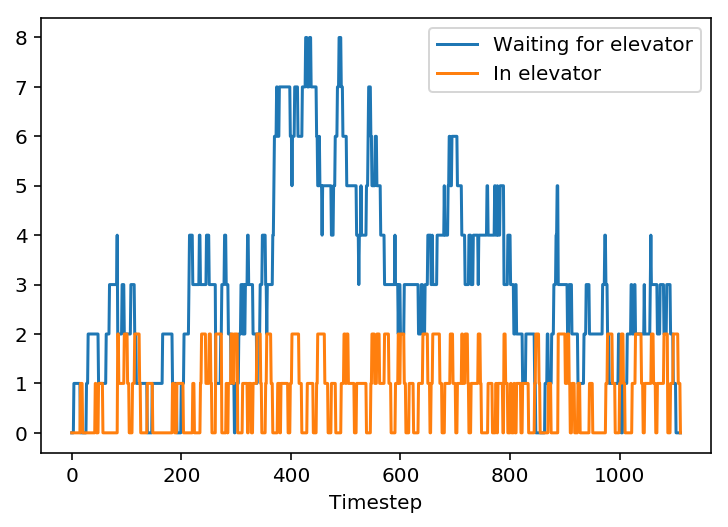

In [299]:
plot_calls = plt.plot(building.calls_over_time, label='Waiting for elevator')
plt.xlabel('Timestep')
plot_requests = plt.plot(building.requests_over_time, label='In elevator')
plt.xlabel('Timestep')
plt.legend(loc=1)
plt.show()


Simulation parameters

In [297]:
#simulation parameters
N = 100 #passengers generated

C = 6 # elevstor capacity
T = range(1800) #time steps
F = 20 #default number of floors

Definition of the elevator class

In [290]:
#class definitions

class Elevator:

    def __init__(self, max_floors = F, default_floor = 1, capacity = C):
        self.max_floors = max_floors
        self.default_floor = default_floor ### i wouldn't use this on our initial iteration
        self.current_floor = self.default_floor ### i would just set this to 1 and delete the attribute default_floor
        self.user_count = 0
        self.capacity = capacity
        self.calls = {} # which user pressed the button and attempting to go in which direction
        self.requests = {} # which buttons were pressed inside the elevator by whom
        self.weight = 0
        self.direction = +1

##Nico's methods    
    
    def add_call(self):
        calling_user = random.choice(list(call_pool.keys()))
        self.calls[calling_user] = call_pool.pop(calling_user) #remove one call from the call_pool, append it to the elevator calls
        return calling_user


    def stop(self): #Returns boolean. Answers the question: Should the elevator stop?
        if (self.current_floor in self.requests.values()):
            return True

        elif (self.direction*self.current_floor in self.calls.values()) and (self.user_count < self.capacity):
            return True
        
            #stop elevator
        else:
            return False
            #move elevator
    
    def swap(self): #will be activated if we need to remove or add passengers

        calls_copy = deepcopy(self.calls) #we want to pop things from dictionary while we iterate
        requests_copy = deepcopy(self.requests) #we want to pop things from dictionary while we iterate

        
        #drop people
        for p,f in requests_copy.items(): #for passenger and floor in the queue of requests
                
            if f == self.current_floor:
                dropped_passenger = self.requests.pop(p) #return dropped passenger and remove it from queue of requests_over_time
                self.user_count -=1
                print('Passenger %d was dropped at floor %d.' %(p, self.current_floor))

                users[dropped_passenger].in_elevator = False # dropped passenger is now outside the elevator
        
        
        
        
        for p,f in calls_copy.items():
            if self.user_count == self.capacity:
                break
            if f == self.direction*self.current_floor: #if floor and direction match call
                added_passenger = self.calls.pop(p) #return added passenger and remove it from queue of calls
                self.user_count +=1
                print('Passenger %d entered the elevator at floor %d.' %(p, self.current_floor))

                users[added_passenger].in_elevator = True # added passenger is now inside the elevator
                self.requests[p] = users[p].destination # add their destination to requests


        
    
    
    def move(self):
            
        if self.direction == 1:
            dir_string = 'up'
        elif self.direction == -1:
            dir_string = 'down'
            
        print('Elevator moves %s from floor %d carrying %d people.' %(dir_string, self.current_floor, self.user_count))
        
        if self.direction == +1:
            self.current_floor += 1
        else:
            self.current_floor -= 1
        
        if self.current_floor >= self.max_floors: #>= for debugging
            self.direction = -1 #direction is either -1 or 1
        
        if self.current_floor == 1:
            self.direction = +1

Definition of the building class

In [291]:
class Building:
    #  
    # Constructor
    def __init__(self, max_floors, elevator,users):
        self.max_floors = max_floors
        self.elevator = elevator
        self.users = users
        self.calls_over_time = [] #store values to plot later
        self.requests_over_time = []
        self.count_over_time = []
        
    def timestep(self,elevator,users,t): #main control function
        #print(elevator.user_count, elevator.current_floor*elevator.direction, elevator.calls) #check evolution of attributes
            
        #check if elevator needs to stop
        if elevator.stop(): #if the elevator stops, do as below
            print('Elevator stops at %d.' %(elevator.current_floor))
            elevator.swap() #add and drop passengers
        else: # if elevator needs to move do as follows
            elevator.move() #move a floor up or down

        if random.random() < 0.1: #10% chance of adding a new call from the pool regardless of action taken
                try:
                    print('User %d called the elevator.' %(elevator.add_call()))
                except:
                    pass
    
    def store_data(self):
        self.calls_over_time.append(len(elevator.calls)) #store final attribute values
        self.requests_over_time.append(len(elevator.requests))
        self.count_over_time.append(elevator.user_count)

Definition of the passenger class

In [292]:
class Passenger:
    # Passengers have origins, destinations, and trackers on whether
    # they are in the elevator and whether they reached their destination
    
    def __init__(self, id, weight, in_elevator = False): #setting default values, otherwise specifiable
        random.seed(id) #im putting the initialization of the two attributes below so that it takes the seed change
        current_floor = random.randint(1, F)
        destination = random.randint(1, F)
        self.id = id
        self.current_floor = current_floor
        while(current_floor == destination):
            destination = random.randint(1, F)
        else:    
            self.destination = destination
            
        self.direction=np.sign(self.destination - self.current_floor) #direction as the sign of the difference
        self.in_elevator = in_elevator
    
    def __str__(self):
        in_string = '' #string to represent direction ('up' or 'down')
        if self.in_elevator == True: in_string = 'inside'
        else: in_string = 'outside'
        
        dir_string = ''
        if self.direction == 1: dir_string = 'up'
        elif self.direction == -1: dir_string = 'down'
        elif self.direction == 0: dir_string = 'nowhere (they are at destination)' #this shouldn't be necessary
        
        return('Passenger %d is %s the elevator, wanting to go %s from floor %d to floor %d.') %(self.id,in_string,dir_string,self.current_floor,self.destination)

Overarching loop

In [298]:
call_pool = {} #dictionary from which to sample elevator calls
calls_over_time = [] #store values to plot later
requests_over_time = []
count_over_time = []

elevator = Elevator() #initialize elevator
users = [Passenger(id=i,weight=round(np.random.normal(70,15))) for i in range(N)] #generate users
building = Building(max_floors = F,elevator=elevator,users=users) #initialize building

for u in users:
    call_pool[u.id] = u.current_floor * u.direction ## IMPORTANT: This replentishes the calling queue!!

for t in T: #main loop
    building.store_data()
    building.timestep(elevator,users,t)
    if len(elevator.requests)!=elevator.user_count:
        print(len(elevator.requests),elevator.user_count)
    
    if (t > 50) and (len(elevator.calls)==0) and (len(elevator.requests)==0) and (len(call_pool)==0):
        print('Simulation over after %d timesteps.' %t)
        break #end simulation if no one is using or calling the elevator

building.store_data()

Elevator moves up from floor 1 carrying 0 people.
Elevator moves up from floor 2 carrying 0 people.
Elevator moves up from floor 3 carrying 0 people.
Elevator moves up from floor 4 carrying 0 people.
User 93 called the elevator.
Elevator moves up from floor 5 carrying 0 people.
Elevator moves up from floor 6 carrying 0 people.
Elevator moves up from floor 7 carrying 0 people.
Elevator moves up from floor 8 carrying 0 people.
Elevator moves up from floor 9 carrying 0 people.
Elevator moves up from floor 10 carrying 0 people.
Elevator moves up from floor 11 carrying 0 people.
Elevator moves up from floor 12 carrying 0 people.
Elevator moves up from floor 13 carrying 0 people.
Elevator moves up from floor 14 carrying 0 people.
Elevator moves up from floor 15 carrying 0 people.
Elevator stops at 16.
Passenger 93 entered the elevator at floor 16.
Elevator moves up from floor 16 carrying 1 people.
Elevator moves up from floor 17 carrying 1 people.
Elevator moves up from floor 18 carrying 1 p